# Data preprocessing

In [125]:
import pandas as pd

stock_data = pd.read_csv("HistoricalData_1727182541271.csv")
stock_data = stock_data["Close/Last"]

ecg_data = pd.read_csv("ecg.csv", header = None, nrows=1001)
ecg_data = ecg_data.iloc[:,0]

pulse_data = pd.read_csv("sensor_20_05_2023_08_55_15.csv")
pulse_data = pulse_data.iloc[10000:11001,0].reset_index(drop=True)


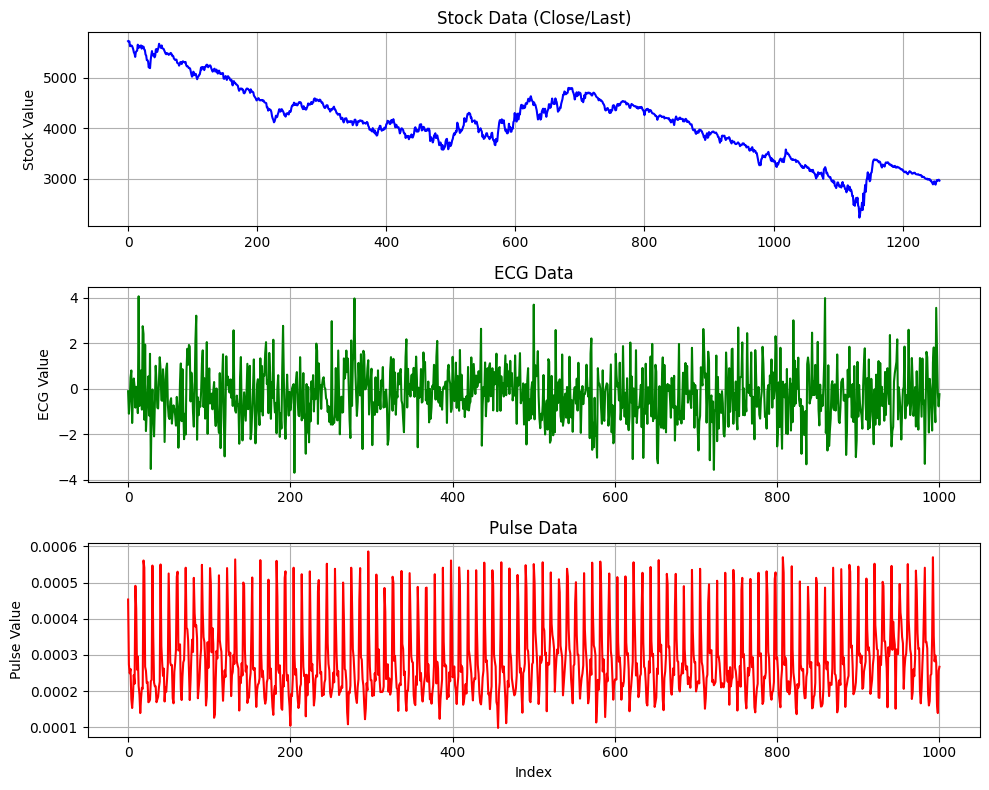

In [126]:
import matplotlib.pyplot as plt
# Plot the data
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=False)

# Plot stock data
axes[0].plot(stock_data, color='blue')
axes[0].set_title('Stock Data (Close/Last)')
axes[0].set_ylabel('Stock Value')
axes[0].grid(True)

# Plot ECG data
axes[1].plot(ecg_data, color='green')
axes[1].set_title('ECG Data')
axes[1].set_ylabel('ECG Value')
axes[1].grid(True)

# Plot Pulse data
axes[2].plot(pulse_data, color='red')
axes[2].set_title('Pulse Data')
axes[2].set_ylabel('Pulse Value')
axes[2].set_xlabel('Index')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [127]:
from sklearn.preprocessing import MinMaxScaler
# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))

stock_data = scaler.fit_transform(stock_data.values.reshape(-1, 1))




# Conventional Reservoir

In [114]:
import numpy as np

def apply_sparsity(W: np.ndarray, sparsity: float) -> np.ndarray:
    """
    Applies sparsity to the given matrix W.
    
    Parameters:
        - W: The matrix to which sparsity will be applied.
        - sparsity: The fraction of elements to be zeros (0 <= sparsity < 1).
    
    Returns:
        The modified matrix with applied sparsity
    """
    total_elements = W.size
    num_nonzero = int(total_elements * sparsity)      
    indices = np.random.choice(np.arange(total_elements),
                            size=num_nonzero,
                            replace=False)
    W.flat[indices] = 0
    return W

def has_valid_eigenvalues(W: np.ndarray) -> bool:
    """
    Checks if the matrix W has no zero eigenvalues.
    
    Parameters:
        - W: The input matrix whose eigenvalues will be checked.
    
    Returns:
        True if the matrix has non-zero eigenvalues, otherwise False.
    """
    eigenvalues = np.linalg.eigvals(W)
    return max(abs(eigenvalues)) > 0

def scale_matrix(W, spectral_radius):
    """
    Scales the matrix W to achieve the desired spectral radius.
    
    Parameters:
        - W: The matrix to scale.
        - spectral_radius: The desired spectral radius.
    
    Returns:
        The scaled matrix, or None if scaling is not possible due to zero eigenvalues.
    """
    eigenvalues = np.linalg.eigvals(W)
    max_eigenvalue = max(abs(eigenvalues))
    
    if max_eigenvalue == 0:
        return None  # Return None if the max eigenvalue is zero (invalid matrix)
    
    return W * (spectral_radius / max_eigenvalue)

In [115]:
import numpy as np

# from src.utils import apply_sparsity, has_valid_eigenvalues, scale_matrix


class Reservoir:
    def __init__(self, 
                 input_size: int, 
                 reservoir_size: int, 
                 output_size: int,
                 reservoir_values_range: float  = 5.0,
                 spectral_radius: float =1.0, 
                 sparsity: float = 0.1, 
                 tmin: int = 10,
                 leaky_rate: float = 0.8,
                 feedback: bool = True,
                 seed = None):
        if seed is not None:
            np.random.seed(seed)

        # Initialize the weight matrices
        self.Win = np.random.choice([0, 1, -1], size = (reservoir_size, input_size), p=[0.5, 0.25, 0.25])
        self.W = self._initialize_reservoir(reservoir_size, reservoir_values_range, spectral_radius, sparsity)
        self.Wout = np.zeros((output_size, reservoir_size))
        self.Wback = np.random.choice([-1, 1], size=(reservoir_size, output_size))

        # Initialize the internal state
        self.x = np.zeros(reservoir_size)
        self.tmin = tmin
        self.leaky_rate = leaky_rate
        self.feedback = feedback
    def _initialize_reservoir(self, size, range_value,
                              spectral_radius, sparsity):
        valid_matrix = False
        while not valid_matrix:
            W = np.random.uniform(-range_value, range_value, (size, size))
            W = apply_sparsity(W, sparsity)
            if not has_valid_eigenvalues(W):
                continue
            W = scale_matrix(W, spectral_radius)
        
            if W is not None:
                valid_matrix = True
        return W

    def _activation(self, x):
        return np.tanh(x)

    def _output_activation(self, x):
        return x

    def update(self, u, y_prev):
        if self.feedback:
            new_x = self._activation(np.dot(self.Win, u) + np.dot(self.W, self.x) + np.dot(self.Wback, y_prev))
        else:
            new_x = self._activation(np.dot(self.Win, u) + np.dot(self.W, self.x))
        self.x = (1 - self.leaky_rate) * self.x + self.leaky_rate * new_x

    def train(self, inputs, outputs, reg=0.01, noise_bound=0.01):
        states = []
        noise = np.random.uniform(-noise_bound, noise_bound, size=outputs.shape)
        outputs = outputs + noise  # Add noise to outputs
        # Update states with teacher forcing
        for t in range(self.tmin, len(inputs)):
            u = inputs[t]
            y_prev = outputs[t-1] if t > 0 else np.zeros(outputs.shape[1])
            self.update(u, y_prev)
            states.append(self.x.copy())

        # Stack states into a T x N matrix (T: number of timesteps, N: reservoir size)
        states = np.vstack(states)

        # Solve for Wout using ridge regression: Wout = Y * X.T * (X * X.T + λI)^-1
        X = states.T
        Y = outputs[self.tmin:].T  # Discard transients from teacher outputs

        self.Wout = np.dot(Y, np.dot(X.T, np.linalg.pinv(np.dot(X, X.T) + reg * np.eye(X.shape[0]))))

        self.last_input = inputs[-1,:]

    def predict(self, n_steps=50):
        predictions = []
        y_pred = self.last_input
        for _ in range(n_steps):
            self.update(y_pred, y_pred)
            y_pred = self._output_activation(np.dot(self.Wout, self.x))
            predictions.append(y_pred)
        return np.array(predictions)



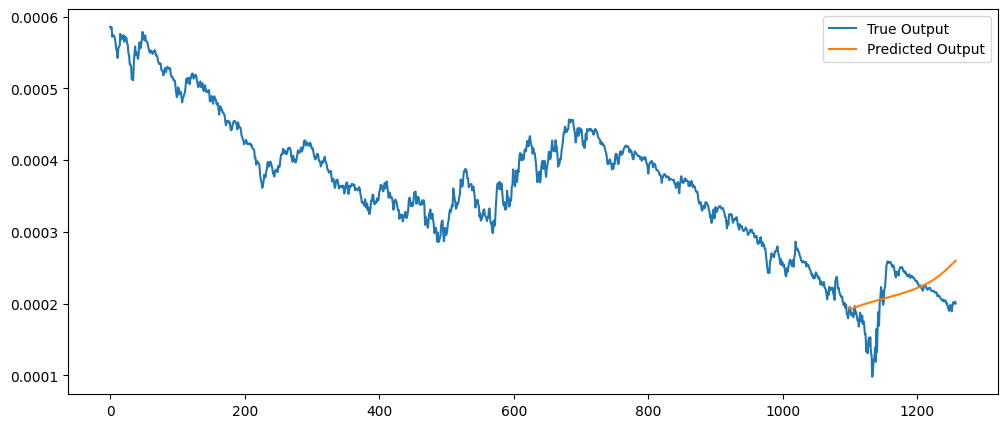

In [ ]:
# Parameters
input_size = 1
reservoir_size = 250
output_size = 1
tmin = 150
start_idx = 1100

# Generate data
input = np.asarray(stock_data[:start_idx]).reshape(-1,1)
output = np.asarray(stock_data[1:start_idx+1]).reshape(-1,1)
# Initialize reservoir
reservoir = Reservoir(input_size, reservoir_size, output_size, tmin=tmin, spectral_radius=1, sparsity=0.95, seed=42, reservoir_values_range = 2)

# Train reservoir
reservoir.train(input, output, reg=0.01)

# Test reservoir (autonomous evolution)
predictions = reservoir.predict(n_steps=len(stock_data)-start_idx)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
plot_data = scaler.inverse_transform(stock_data)

# Plot results
prediction_range = np.arange(start_idx, start_idx + len(predictions))
plt.figure(figsize=(12,5))
# Plot the full true data series
plt.plot(np.arange(len(plot_data)), plot_data, label='True Output')

# Plot the predictions starting at index 1101
plt.plot(prediction_range, predictions, label='Predicted Output')

plt.legend()
plt.show()

In [131]:
from sklearn.preprocessing import MinMaxScaler
# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
ecg_data = scaler.fit_transform(ecg_data.values.reshape(-1, 1))



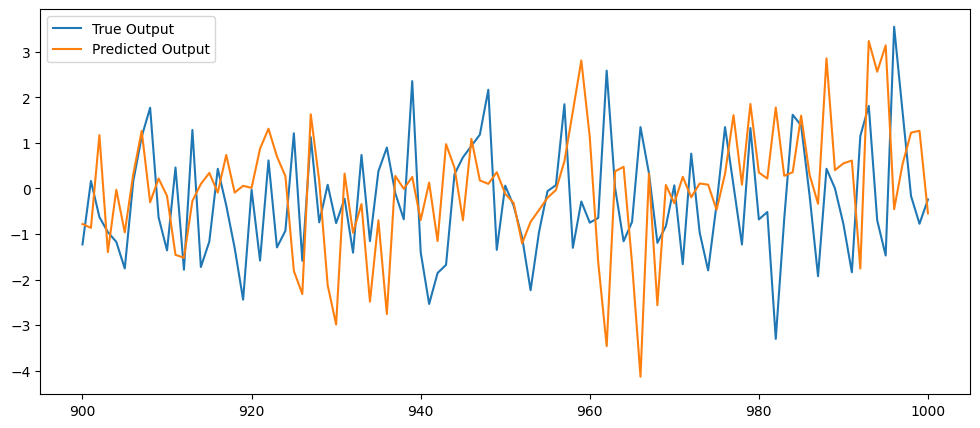

In [118]:
# Parameters
input_size = 1
reservoir_size = 400
output_size = 1
tmin = 100
start_idx = 900

# Generate data
input = np.asarray(ecg_data[:start_idx]).reshape(-1,1)
output = np.asarray(ecg_data[1:start_idx+1]).reshape(-1,1)
# Initialize reservoir
reservoir = Reservoir(input_size, reservoir_size, output_size, tmin=tmin, spectral_radius=1.3, sparsity=0.95, seed=42, reservoir_values_range = 4)

# Train reservoir
reservoir.train(input, output, reg=0.01)

# Test reservoir (autonomous evolution)
predictions = reservoir.predict(n_steps=len(ecg_data)-start_idx)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Create a range for predictions starting at 1101
prediction_range = np.arange(start_idx, start_idx + len(predictions))
# Plot the full true data series
plt.figure(figsize=(12,5))
plt.plot(prediction_range, scaler.inverse_transform(ecg_data[start_idx:]), label='True Output')

# Plot the predictions starting at index 1101
plt.plot(prediction_range, predictions, label='Predicted Output')

plt.legend()
plt.show()

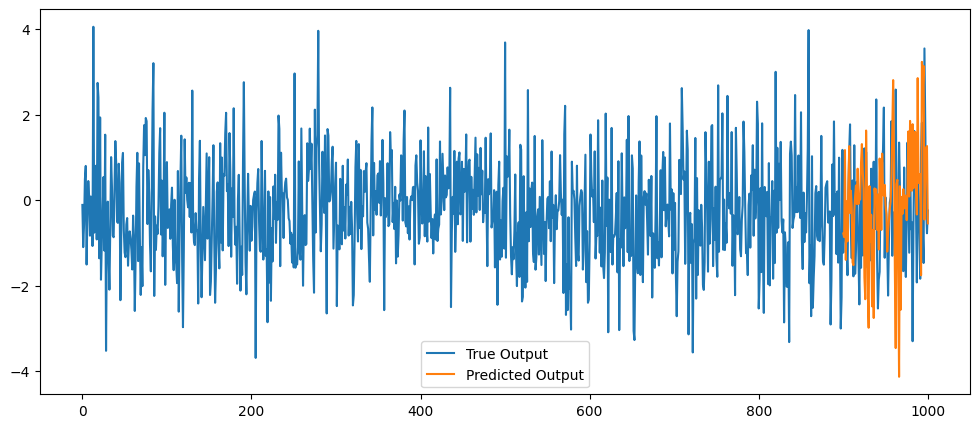

In [119]:

prediction_range = np.arange(start_idx, start_idx + len(predictions))
# Create a range for predictions starting at 1101
plot_data = scaler.inverse_transform(ecg_data)
plt.figure(figsize=(12,5))
# Plot the full true data series
plt.plot(np.arange(len(plot_data)), plot_data, label='True Output')

# Plot the predictions starting at index 1101
plt.plot(prediction_range, predictions, label='Predicted Output')

plt.legend()
plt.show()

In [128]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
pulse_data = scaler.fit_transform(pulse_data.values.reshape(-1, 1))

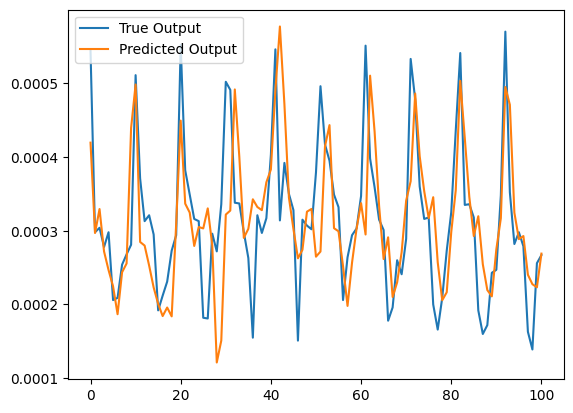

In [129]:
# Parameters
input_size = 1
reservoir_size = 200
output_size = 1
tmin = 100
start_idx = 900

# Generate data
input = np.asarray(pulse_data[:start_idx]).reshape(-1,1)
output = np.asarray(pulse_data[1:start_idx+1]).reshape(-1,1)

# Initialize reservoir
reservoir = Reservoir(input_size, reservoir_size, output_size, tmin=tmin, spectral_radius=1, sparsity=0.95, seed=42, reservoir_values_range = 1)

# Train reservoir
reservoir.train(input, output, reg=0.01)

# Test reservoir (autonomous evolution)
predictions = reservoir.predict(n_steps=len(pulse_data)-start_idx)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

import matplotlib.pyplot as plt
# Create a range for predictions starting at 1101
prediction_range = np.arange(len(predictions))
# Plot the full true data series
plt.plot(prediction_range, scaler.inverse_transform(pulse_data[start_idx:]), label='True Output')
plt.plot(prediction_range, predictions, label='Predicted Output')

plt.legend()
plt.show()

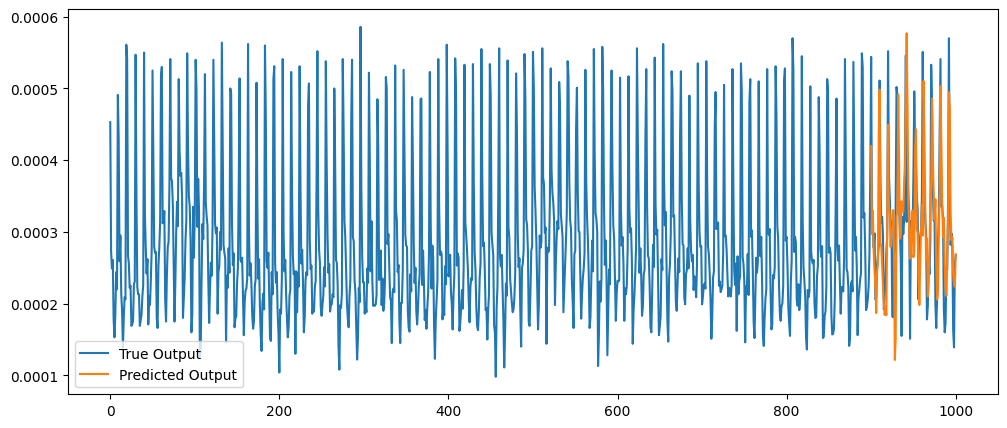

In [124]:

prediction_range = np.arange(start_idx, start_idx + len(predictions))
# Create a range for predictions starting at 1101
plot_data = scaler.inverse_transform(pulse_data)
plt.figure(figsize=(12,5))
# Plot the full true data series
plt.plot(np.arange(len(plot_data)), plot_data, label='True Output')

# Plot the predictions starting at index 1101
plt.plot(prediction_range, predictions, label='Predicted Output')

plt.legend()
plt.show()